In [61]:
import matplotlib.pyplot as plt
import numpy as np 
from astropy.io  import ascii 
from astropy.table import Table
from astropy import  units as u 
import glob 
import scipy as sp 
import warnings 
warnings.simplefilter("ignore")
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity 

In [62]:
idscope ="SAT"
files = glob.glob(f'../SO_E2E_Passbands/{idscope}/Baseline/SO_{idscope}_E2E_Passband_V3*')
print(len(files) ) 

6


Text(0.5, 1.0, 'SO bandpasses  SAT')

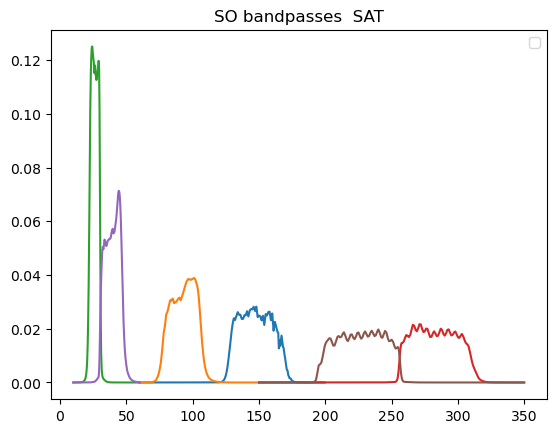

In [63]:

for f in files: 
    label = ((f.split(".")[1][-3:] ))
    arr =np.loadtxt(f,skiprows=1)
    plt.plot(arr[:,0], arr[:,1]/np.trapz(arr[:,1],arr[:,0]), label=label ) 
bnu = arr[:,1] 
nu = arr[:,0]    
plt.legend() 
plt.title(f'SO bandpasses  {idscope}')


## Simulation of bandpasses 


1.  normalize the bpass , so that $ \int b_{\nu} d\nu =1 $ 
2. interpolate the cumulative function $C (\nu) = \int _{\nu_{min} } ^{\nu} d \nu b_{\nu} $
3. bootstrap resample with probability $b_{\nu}$ frequencies with the measured bpass 
4. use Gaussian Kernel Density Estimates from the bootstrap frequencies to sample a new band, (after Gridsearched for the optimal kernel width) 
5. generate $N_{waf}$  resampled bpasses  for each LAT wafer  and for each freq. band   


### Definition of Band centroid and bandwidth 

assuming that 
$$ \int b({\nu}) d\nu =1 
$$

$$ \bar{\nu} =\int \nu b({\nu}) d\nu  
$$
and 
$$ \Delta{\nu}^2 =\int (\nu -\bar{\nu})^2 b({\nu}) d\nu  
$$

In [64]:


def bandpass_distribution_function(bnu , nu ): 
    A=np.trapz( bnu ,nu)
    #normalize it to make it a PDF 
    if A !=1 : bnu/=A  
        
    #Interpolate the band 
    b = sp.interpolate.interp1d(x=nu, y=bnu ) 
    #estimate the CDF 
    Pnu =np.array([sp.integrate.quad(b , a =nu.min(), b=inu  )[0]  for inu in nu[1:] ]) 
    #interpolate the inverse CDF
    Binterp = sp.interpolate.interp1d(Pnu ,nu[:-1] + np.diff(nu), bounds_error=False, fill_value="extrapolate")  
    return Binterp


def search_optimal_kernel_bwidth (x  ):

    bandwidths =  np.logspace(np.log(.1), np.log(2) , 64) 
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=LeaveOneOut() )  
    grid.fit(x[:, None]);
    return  grid.best_params_['bandwidth'] 
    
def bandpass_kresampling(h, nu_i ,range , nresample=54 ): 
    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=h, kernel='gaussian')
    kde.fit(nu_i[:, None])
    nud = np.linspace(*range , nresample ) 
    # score_samples returns the log of the probability density
    resampled_bpass  = np.exp(kde.score_samples(nud[:, None]) ) 
    
    return nud , resampled_bpass

def bandpass_resampling(Binterp, nu, bstrap_size= 1000, nresample=54 ): 
    X =  np.random.uniform(size=bstrap_size)
    bins_nu=np.linspace(nu.min()*1.1, nu.max()*1.2,nresample)
    
    h, xb =np.histogram(Binterp( X ), density=True ,bins= bins_nu   )
    
    nu_b  = xb[:-1] + np.diff(xb)
    resampled_bpass =abs(sp.interpolate.interp1d(nu_b, h, kind='slinear', bounds_error=False, fill_value=0. )(nu))
    return nu, resampled_bpass/np.trapz(resampled_bpass,nu )



2.8535839320460967


Text(0.5, 0, 'GHz')

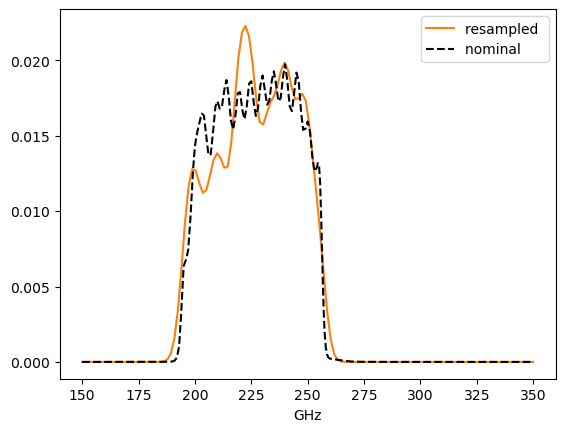

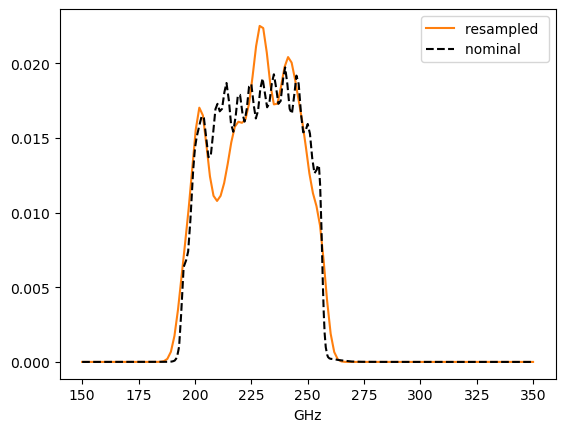

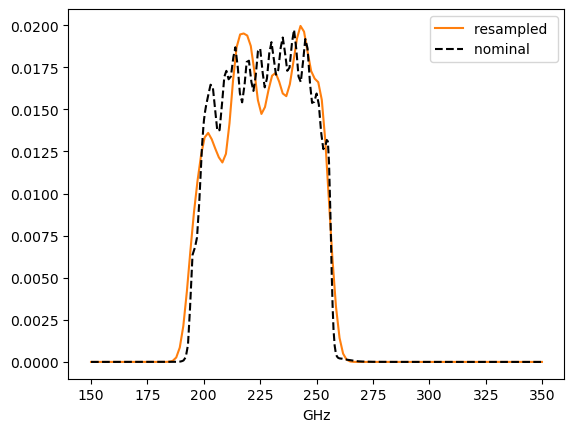

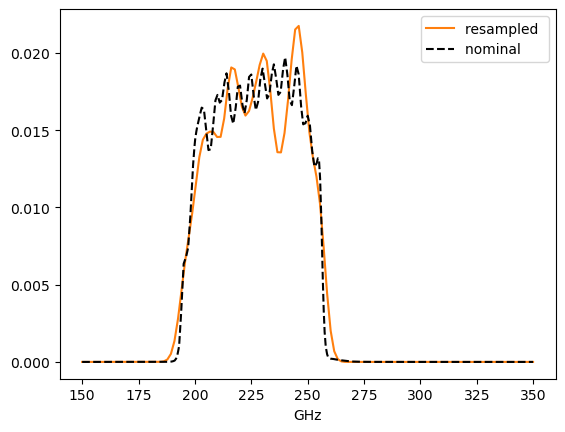

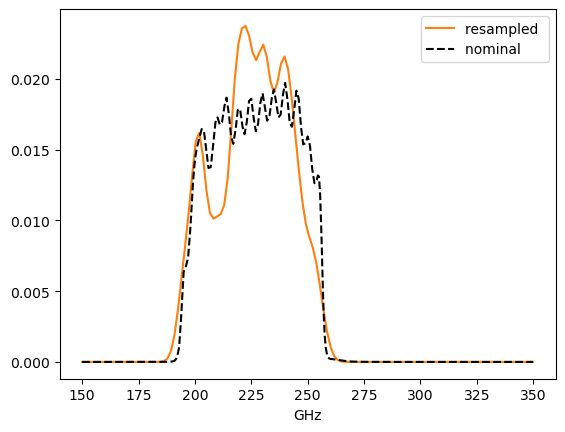

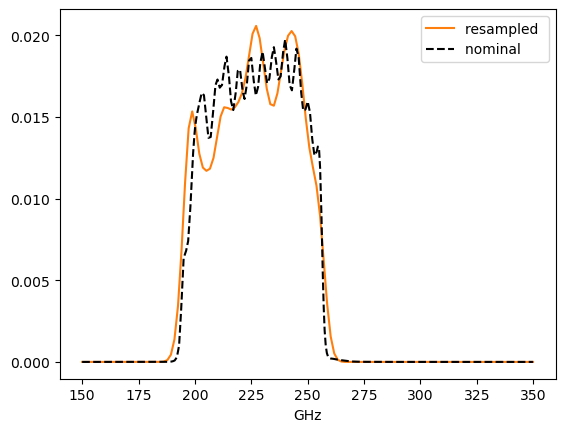

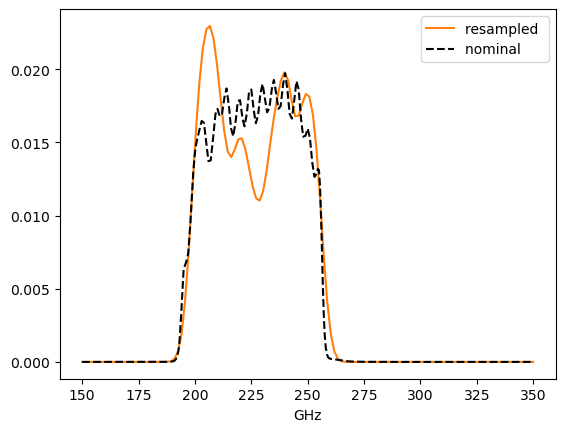

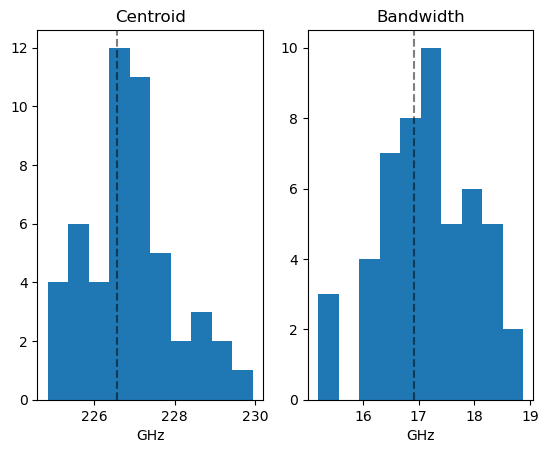

In [65]:
norm = np.trapz(bnu,nu )

bnu /=norm 
mom1 = lambda x ,f  : np.trapz(f*x,x )
mom2 = lambda x,f:  np.trapz (f *(x - mom1(x,f))**2 ,x )
interpolated_cdf  = bandpass_distribution_function(bnu = bnu, nu =nu  )
centroid =[] 
width=[] 
h =0.  
bstrap_size= 128 #np.int_(np.floor(nu.size    *np.log(nu.size)**2) ) # /!\  it's more advised to  use N (log N^2 ) 

np.random.seed(1929) 
 
for i in range( 50): 

    X =  np.random.uniform(size=bstrap_size)
    nuresampled = interpolated_cdf( X )
    if h==0: 
        h = search_optimal_kernel_bwidth(nuresampled ) 
        print(h  ) 
    fr, resampled_band = bandpass_kresampling(h , nuresampled ,range = [nu.min(), nu.max() ], nresample=bstrap_size   ) 
    fbar = mom1(fr ,resampled_band  )  
    variance = mom2(fr ,resampled_band  )  
    centroid .append( fbar  )
    width .append( np.sqrt(variance ) )
    if i<7: 
        plt.figure()
        plt.plot(fr, resampled_band ,alpha=1, color= 'C1', label='resampled ')
        plt.plot(nu, bnu ,'--', color='black' ,alpha=1, label='nominal ' )
        plt.xlabel('GHz')
        plt.legend() 
    
nubar= np.trapz(nu *bnu , nu )

plt.figure()
plt.subplot(121)
plt.title('Centroid' ) 
plt.hist(centroid ) 
plt.xlabel('GHz' ) 
plt.axvline(np.trapz(nu *bnu,nu )  , ymax=1,linestyle='--', color='black' ,alpha=.5) 
#plt.hist(width  ) 
plt.subplot(122)
plt.title('Bandwidth' )
plt.hist(width  ) 
plt.axvline(np.sqrt((np.trapz((nu  - nubar)**2*bnu , nu )) )  , ymax=1,linestyle='--', color='black' ,alpha=.5) 
plt.xlabel('GHz' ) 


Resampling with 128samples
MF2	 centroid 	 Bandwidth
	 147.7346	11.9097
Optimal Gaussian kernel width 2.2923875390385646
Resampled bands 
  	 147.9948	   12.1831
  	 147.8798	   12.2374
  	 147.9147	   12.4907
  	 148.2709	   12.2868
  	 146.8562	   11.3555
  	 147.6248	   12.3415
  	 147.8648	   12.8012
  	 147.8306	   11.7036
Resampling with 128samples
MF1	 centroid 	 Bandwidth
	 93.1830	8.9283
Optimal Gaussian kernel width 2.2923875390385646
Resampled bands 
  	 93.3451	   9.2530
  	 93.2879	   9.3427
  	 93.2322	   9.4750
  	 93.5646	   9.2771
  	 92.6034	   8.7770
  	 93.0582	   9.4034
  	 93.1945	   9.6087
  	 93.2475	   8.7517
Resampling with 128samples
LF1	 centroid 	 Bandwidth
	 26.0830	2.5968
Optimal Gaussian kernel width 0.8557093663708575
Resampled bands 
  	 26.1189	   2.7551
  	 26.1015	   2.7722
  	 26.0915	   2.8280
  	 26.1891	   2.7601
Resampling with 128samples
HF2	 centroid 	 Bandwidth
	 283.1327	15.7757
Optimal Gaussian kernel width 2.2923875390385646
Resampled ban

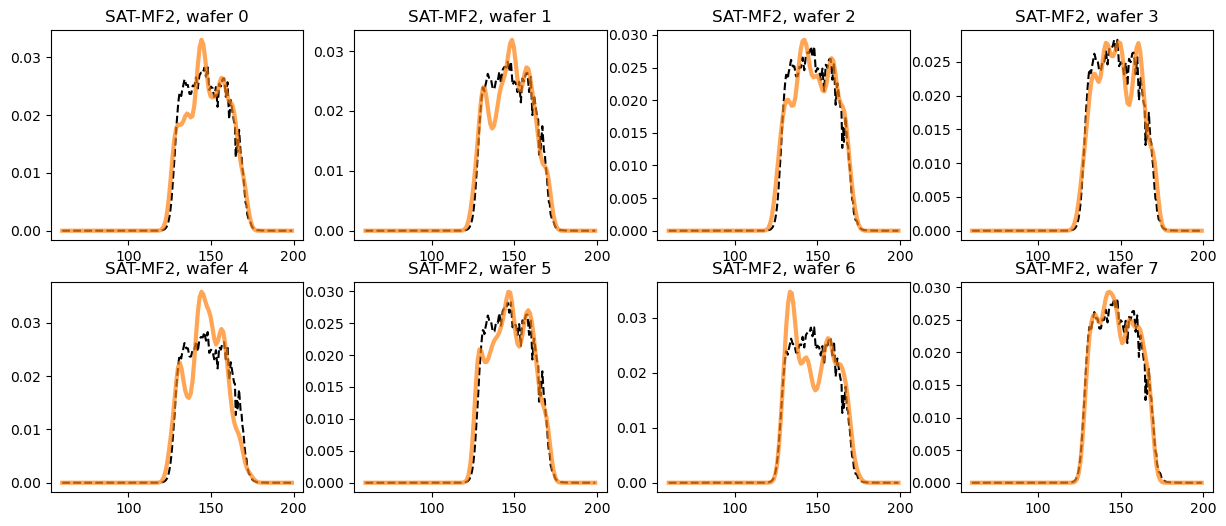

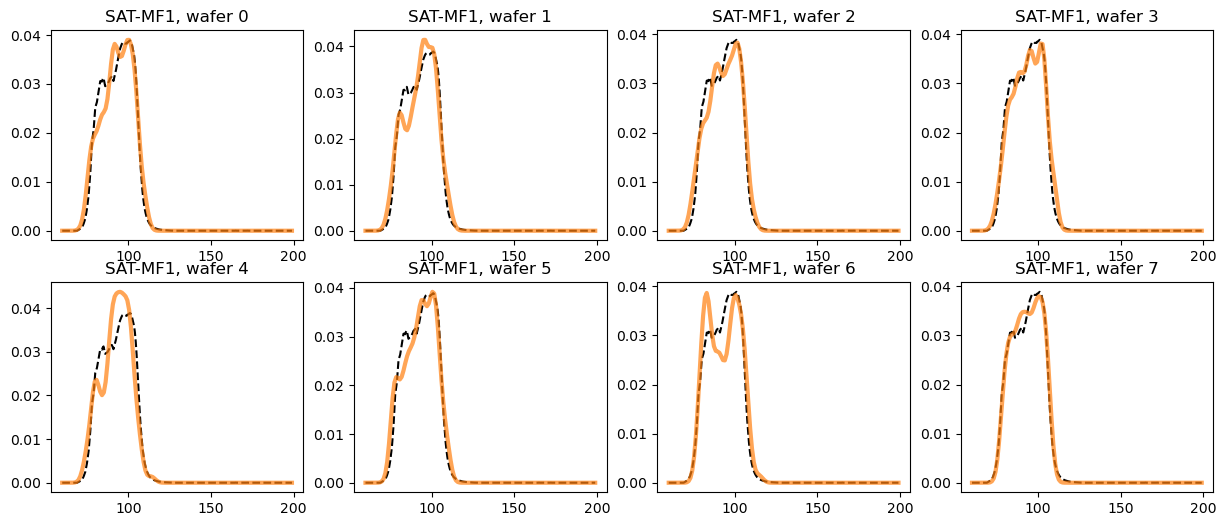

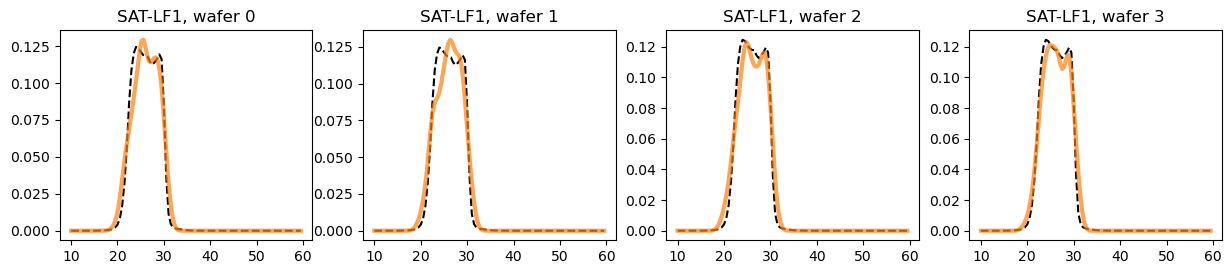

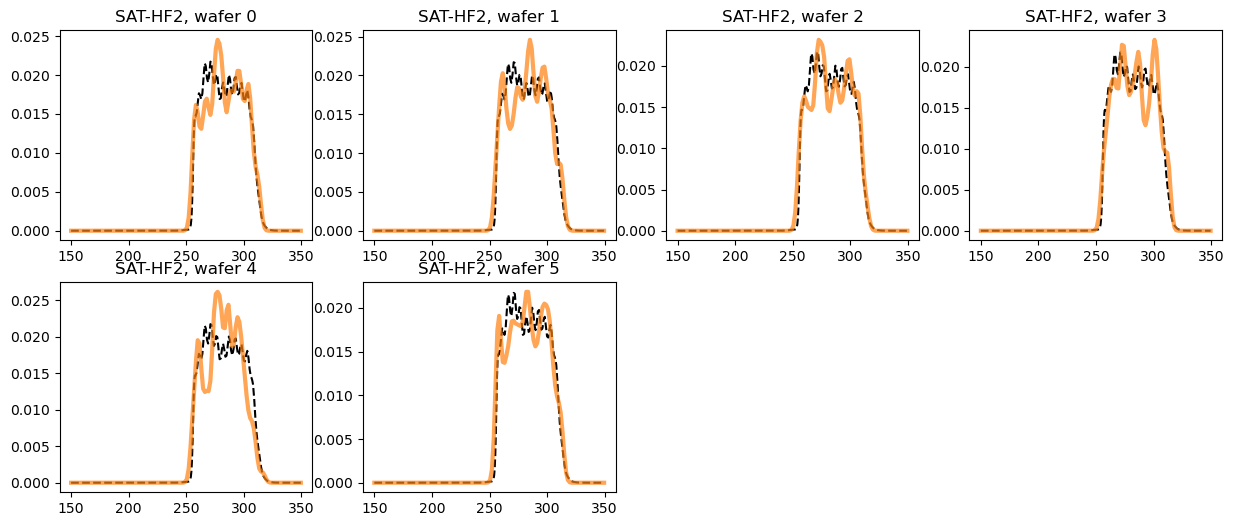

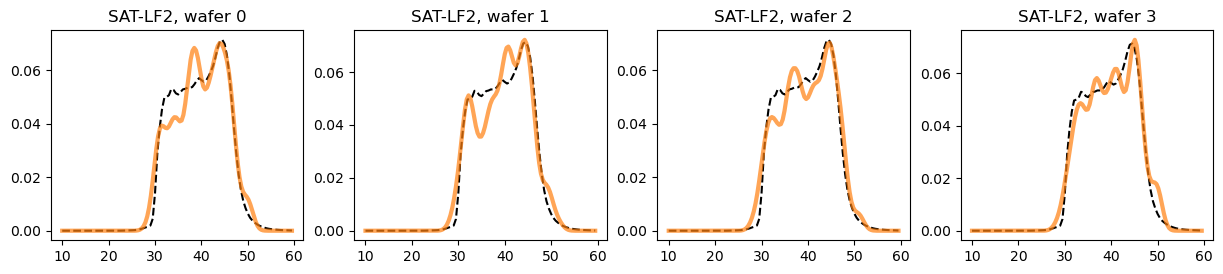

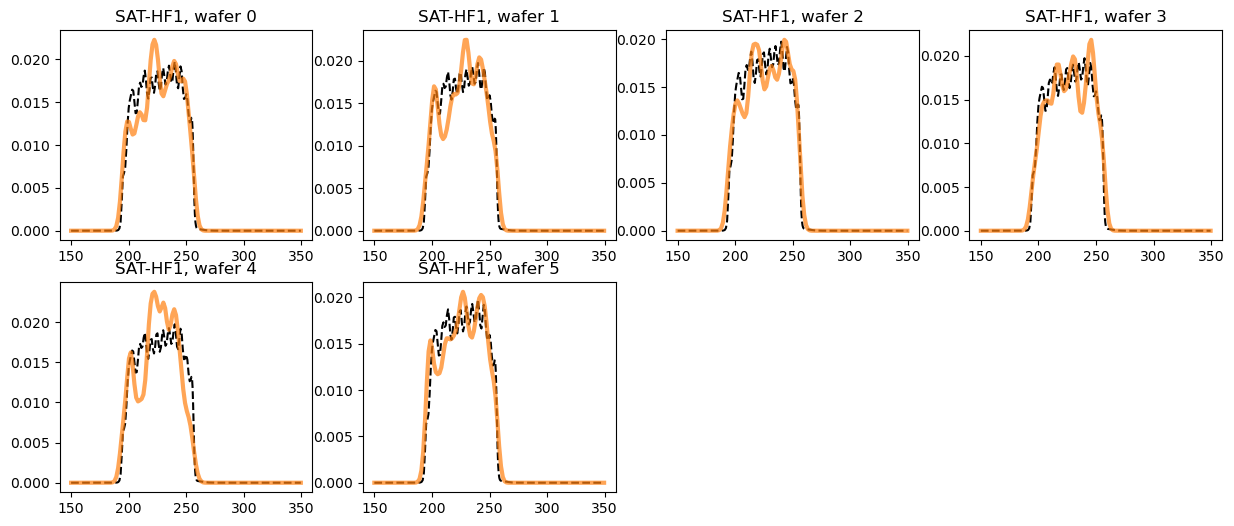

In [66]:

dic_nwaf = {"LF1":4, "MF1":8, "HF1":6,
           "LF2":4, "MF2":8, "HF2":6}    
for f in files: 
    idfreq  = ((f.split(".")[-2][-3:] ))
    Nwafers=dic_nwaf[idfreq] 
    arr =np.loadtxt(f,skiprows=1)
    
    bnu = arr[::5,1] 
    nu = arr[::5,0]   

    bnu /=np.trapz(bnu,nu )
    norm = np.trapz(bnu,nu )
    interpolated_cdf  = bandpass_distribution_function(bnu = bnu, nu =nu  )
    
    bstrap_size= 128 #np.int_(np.floor(nu.size    *np.log(nu.size)**2) ) # use N (log N^2 ) 
    print(f"Resampling with {bstrap_size}samples")

    nubar= mom1(nu, bnu) 
    nuvar=  np.sqrt(mom2(nu, bnu) )
    print( f"{idfreq}\t centroid \t Bandwidth\n\t {nubar:.4f}\t{nuvar:.4f}" ) 
    plt.figure(figsize=(15,6) ) 
    np.random.seed(1929) 
    h =0.
    data = Table()
    
    for i in range( Nwafers  ): 

        plt.subplot(241+i) 
        plt.plot(nu, bnu ,'--', color='black' ,alpha=1  )
        
        plt.title(f"{idscope}-{idfreq}, wafer {i}") 
        
        X =  np.random.uniform(size=bstrap_size)
        nuresampled = interpolated_cdf( X )
        
        if h==0: 
            h = search_optimal_kernel_bwidth(nuresampled ) 
            print(f"Optimal Gaussian kernel width {h}\nResampled bands ") 

        fr, resampled_band = bandpass_kresampling(h , nuresampled ,range = [nu.min(), nu.max() ], nresample=bstrap_size   ) 
        fbar = mom1(fr ,resampled_band  )  
        variance = np.sqrt(mom2(fr ,resampled_band  )  ) 
        print( f"  \t { fbar :.4f}\t   { variance :.4f}" ) 

        plt.plot(fr, resampled_band,color="C1" , alpha=.7,lw=3,  label=r"$\bar{\nu}=$"+f"{fbar:.2f} GHz,"+r"$ \Delta \nu =$"+f"{variance:.2f} GHz")
        #plt.xlabel('GHz')
        #plt.legend() 
        data[f'bandpass_frequency'] = fr *u.GHz 
        data[f'bandpass_weights'] = resampled_band   
        data.write(f'./{idscope}/resampled_bpasses_{idfreq}_w{i}.tbl', format='ascii.ipac', overwrite=True)  
    plt.savefig(f'./{idscope}/{idscope}_{idfreq}_wafer_bands.pdf')



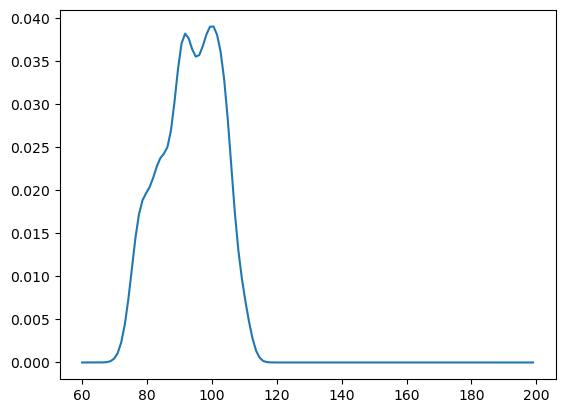

In [67]:
from astropy.table import QTable
tab= QTable.read(f'{idscope}/resampled_bpasses_MF1_w0.tbl', format='ascii.ipac')

plt.plot(tab ["bandpass_frequency" ] ,tab ["bandpass_weights" ] ) 

In [59]:
tab.columns

<TableColumns names=('bandpass_frequency','bandpass_weights')>